<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>DECam HiTS Analysis Notebook</b> <br>
Contact author: Erin Howard<br>
Last verified to run: November 28, 2022<br>
LSST Science Piplines version: w_2022_39<br>
Container Size: Large <br>

# DM-36024: ApPipeWithFakes on DECam HiTS, October 2022

New baseline run, still using "old diffim" (before the big refactor).

* Uses `decam_rings_v1` skymap
* Templates from HiTS 2014 are in `/sdf/group/rubin/repo/main/u/elhoward/DM-36024/templates`
* Final processing of HiTS 2015 is in `u/elhoward/DM-36024/hits2015-fakes-postgresTest`
* Postgres schema is `elhoward_dm36024_hits_appipewithfakes`
* Working directory on USDF with bps logs, pipelines, etc. is `/project/elhoward/repo-main-logs/DM-36024`

For ApTemplate.yaml:
```
inCollection: DECam/defaults/hits2014,u/mrawls/DM-34710-hits-crosstalk-sources
dataQuery: "instrument='DECam' AND skymap='decam_rings_v1' AND detector=42 AND exposure<300000"
```
For ApPipeWithFakes.yaml:
```
inCollection: DECam/defaults/hits2015,u/mrawls/DM-34710-hits-crosstalk-sources,u/mrawls/DM-34710/templates
dataQuery: "instrument='DECam' AND skymap='decam_rings_v1' AND detector NOT IN (2, 61) AND exposure>400000"
```

Notes: The exposure cuts are necessary to force each pipeline to use only the 2014 images (numbered in the 200000s) for template building, and to use only the 2015 images (numbered in the 400000s) as science images.

## Table of Contents

1. Loading DiaObjects and DiaSources
2. Typical "quick look analysis" plots
3. Separating the fake sources from the real sources
4. Fakes completeness analysis
5. SNR distributions

In [1]:
%matplotlib widget

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyCoaddAnalysis
from lsst.analysis.ap import legacyPlotUtils as plac

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/dustmaps_cachedata/g41a3ec361e+62d12e78cb/config/.dustmapsrc


<module 'lsst.analysis.ap.legacyApdbUtils' from '/sdf/data/rubin/u/elhoward/repos/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py'>

## 1. Loading DiaObjects and DiaSources

In [2]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
collections = 'u/elhoward/DM-36024/hits2015-fakes-postgresTest' #payloadName from bps yaml
instrument = 'DECam'
skymap = 'decam_rings_v1'
schema = 'elhoward_dm36024_hits_appipewithfakes'

dbType='postgres'
dbName='lsst-devl'

month = 'October'
year = '2022'

prevMonth = 'December'
prevYear = '2022'

In [3]:
objTable, srcTable, goodObj, goodSrc = utils.loadTables(repo,
                                                      dbName=dbName,
                                                      dbType=dbType,
                                                      instrument=instrument,
                                                      schema=schema)

In [4]:
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = utils.makeSrcTableFlags(srcTable, objTable,
                                                                                 instrument=instrument,
                                                                                 repo=repo)

In [5]:
objTable.columns

Index(['diaObjectId', 'ra', 'decl', 'nDiaSources', 'gPSFluxMean',
       'rPSFluxMean', 'iPSFluxMean', 'zPSFluxMean', 'yPSFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

In [6]:
srcTable.columns

Index(['diaSourceId', 'diaObjectId', 'ra', 'decl', 'ccdVisitId', 'midPointTai',
       'apFlux', 'psFlux', 'apFluxErr', 'psFluxErr', 'totFlux', 'totFluxErr',
       'x', 'y', 'snr', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'flags', 'filterName',
       'visit', 'detector', 'instrument'],
      dtype='object')

## 2. Typical "quick look analysis" plots

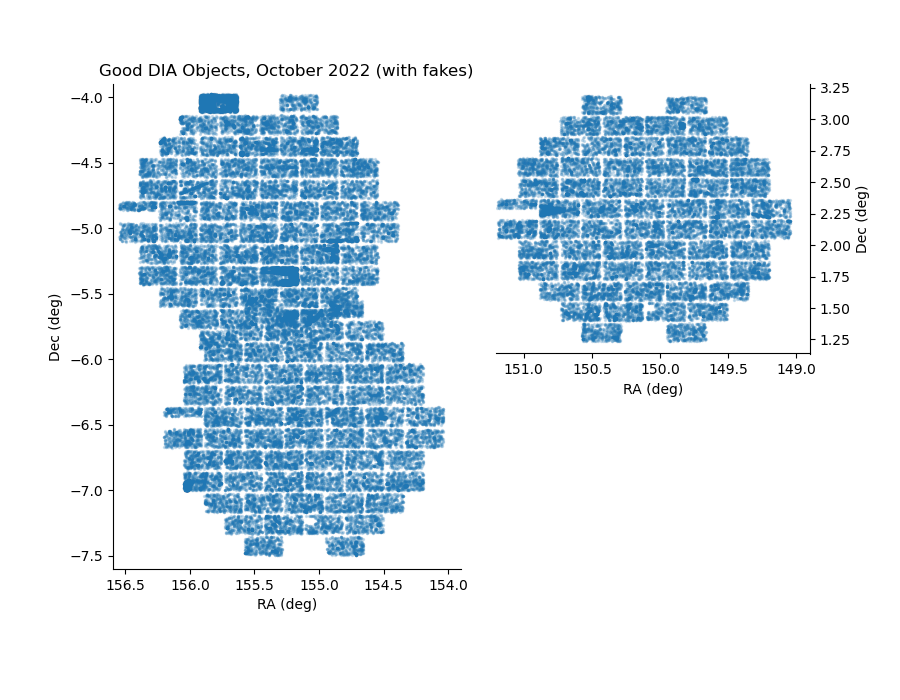

In [7]:
hitsPlot = plac.plotHitsSourcesOnSky(goodObj, title=f'Good DIA Objects, {month} {year} (with fakes)')

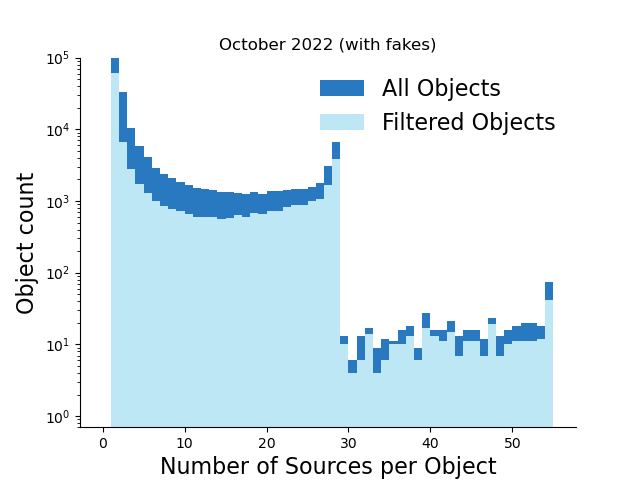

In [8]:
hist = plac.plotDiaObjectHistogram(objTable, goodObj, title=f'{month} {year} (with fakes)')

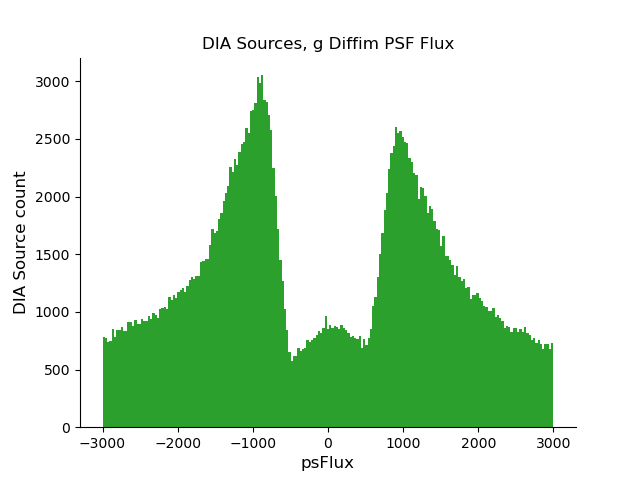

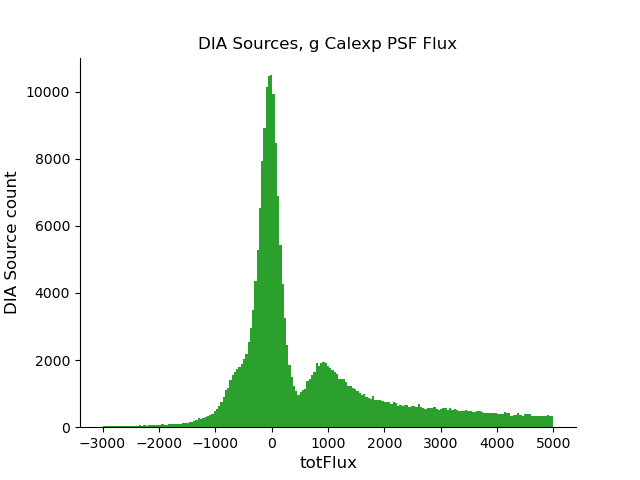

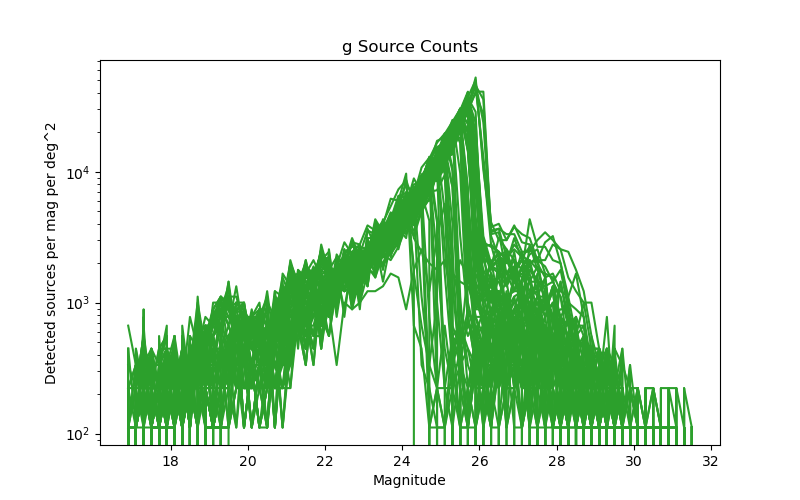

In [9]:
bandList = ['g']
colorList = ['C2']
collection = collections

for band, color in zip(bandList, colorList):
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='psFlux',
                        title=f'DIA Sources, {band} Diffim PSF Flux', color1=color, binmin=-3e3, binmax=3e3)
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='totFlux',
                        title=f'DIA Sources, {band} Calexp PSF Flux', color1=color, binmin=-3e3, binmax=5e3)
    plac.source_magnitude_histogram(repo, goodSrc, band, 'DECam', collection)

In [10]:
def spatial_flag_plot(df, flagName1, flagName2=None, operator=None, plotFlagged=True, plotUnFlagged=True, title=''):
    if flagName2 and operator:
        if operator == 'or':
            flagFilter = ((df[flagName1]) | (df[flagName2]))
            labelTrue = flagName1 + ' \nor ' + flagName2
            labelFalse = 'Neither ' + flagName1 + ' \nnor ' + flagName2
        elif operator == 'and':
            flagFilter = ((df[flagName1]) & (df[flagName2]))
            labelTrue = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse = 'Not ' + flagName1 + ' \nand ' + flagName2
        else:
            raise ValueError('Operator must be \'and\' or \n \'or\'')
    elif flagName2 and not operator:
        raise ValueError('Operator must be set if a second flag is given')
    else:  # just considering one flag
        flagFilter = (df[flagName1])
        labelTrue = flagName1
        labelFalse = 'No ' + flagName1
    flagFilterInverse = ~flagFilter
    
    fig, ax = plt.subplots(figsize=(9,6))
    if plotFlagged:
        scatterFlagged = ax.scatter(df.loc[flagFilter, 'ra'], df.loc[flagFilter, 'decl'], 
                    color='C3', s=5, alpha=0.2, label=labelTrue)
    if plotUnFlagged:
        scatterUnflagged = ax.scatter(df.loc[flagFilterInverse, 'ra'], df.loc[flagFilterInverse, 'decl'], 
                    color='C0', s=5, alpha=0.2, label=labelFalse)
    print('Flagged sources: {0}'.format(len(df.loc[flagFilter, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df.loc[flagFilterInverse, 'ra'])))
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    xlim = (150.8, 149.8)
    ylim = (2.4, 3.1)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    
    plt.title(title)

Flagged sources: 592456
Unflagged sources: 628110


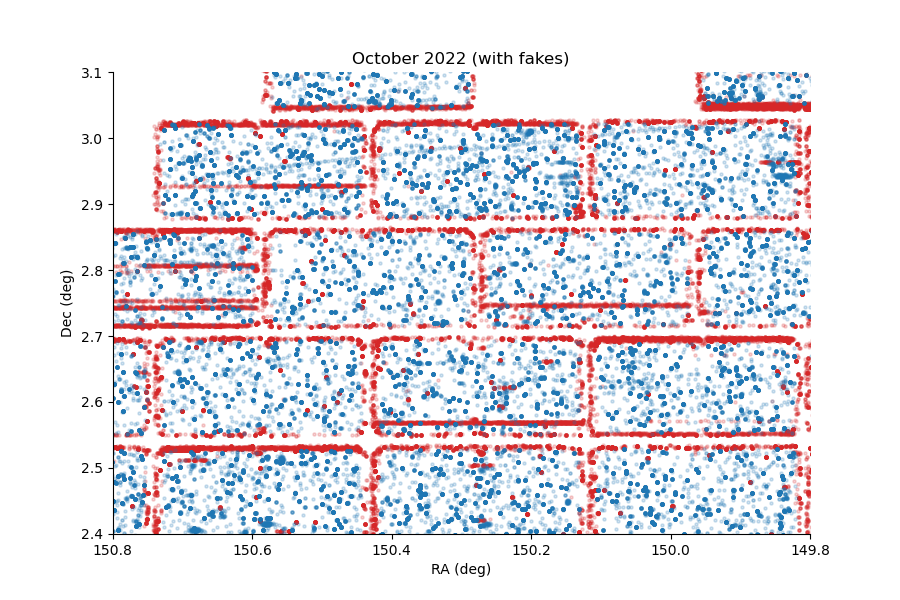

In [11]:
spatial_flag_plot(srcTableFlags, 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_suspect', operator='or',
                  title=f'{month} {year} (with fakes)')

Text(0.5, 1.0, 'October 2022 (with fakes)')

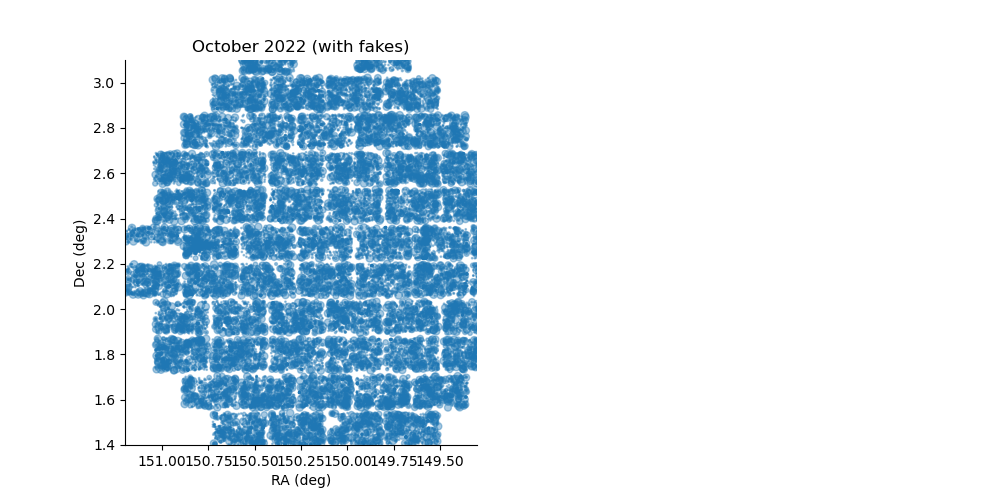

In [12]:
fig = plt.figure(figsize=(10,5))

xlim = (151.2, 149.3)
ylim = (1.4, 3.1)

ax = fig.add_subplot(121)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj['ra'], goodObj['decl'], c='C0', s=goodObj['nDiaSources'], marker='o', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'{month} {year} (with fakes)')

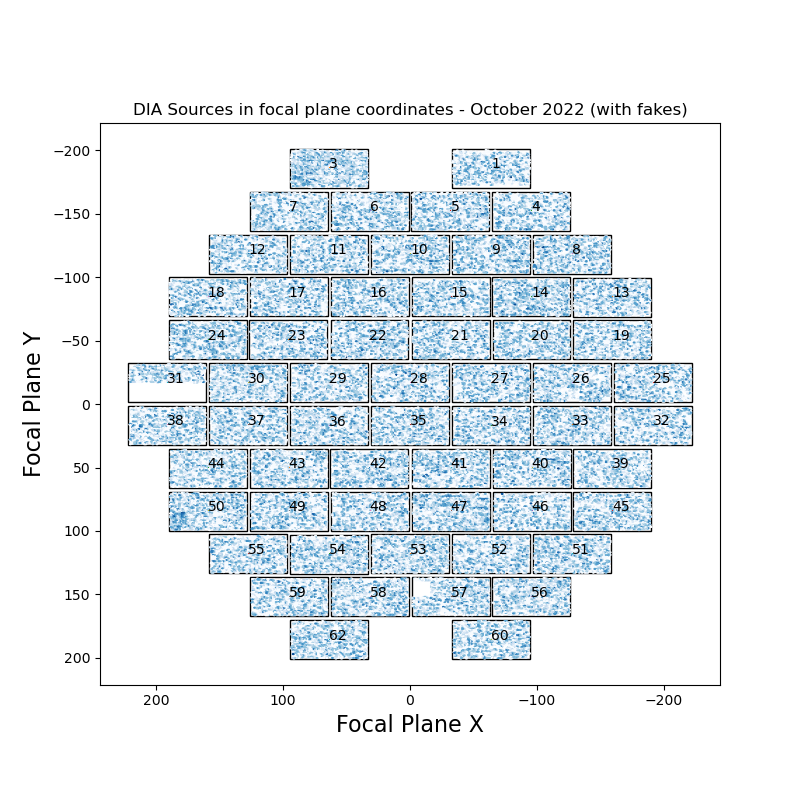

In [13]:
plac.plotDiaSourcesInFocalPlane(repo, goodSrc, title=f'- {month} {year} (with fakes)', instrument='DECam',
                               collections=collections)

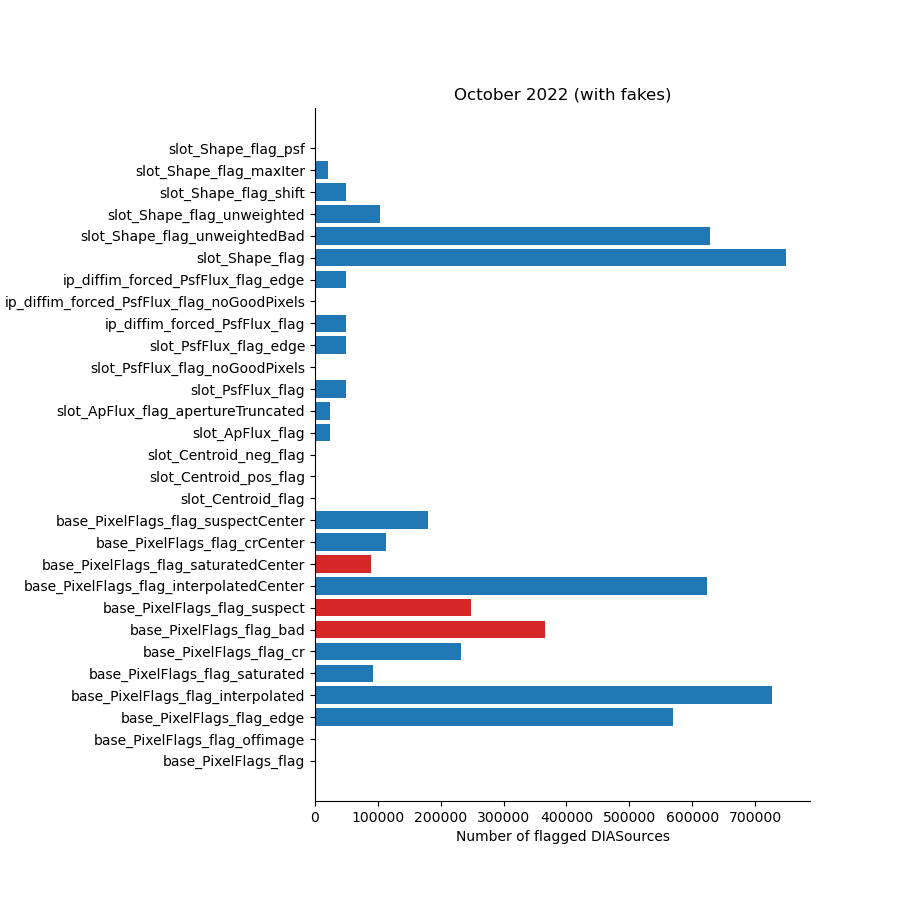

In [14]:
plac.plotFlagHist(srcTable, title=f'{month} {year} (with fakes)')

## 3. Separating the fake sources from the real sources

In [15]:
tractList = [10054, 10055, 10056, 8122, 8123, 8362, 8363, 8364, 8604, 8605,
             8846, 8847, 9570, 9571, 9812, 9813, 9814]

In [16]:
dfs = [butler.get('fakes_fakeSourceCat', collections=collections,
                 instrument=instrument, skymap=skymap, tract=tract) for tract in tractList]
allInjectedFakes = pd.concat(dfs, ignore_index=True)

In [17]:
allInjectedFakes

fakeId       dec        ra  isVisitSource  \
0       10852527423563598949  0.055121  2.603926           True   
1       10842101299372729427  0.061915  2.616994           True   
2       12133549366799691960  0.080659  2.610914           True   
3       13660591819591264140  0.061271  2.594199           True   
4       11770774242097268314  0.074790  2.601716           True   
...                      ...       ...       ...            ...   
162872  11332776983199523178  0.027589  2.666088          False   
162873   9322634178528806282  0.042351  2.640017          False   
162874  11052643217652500170  0.043082  2.668239          False   
162875  11142532224924191225  0.055073  2.643180          False   
162876  10921524966738023923  0.028025  2.651862          False   

        isTemplateSource      u_mag      g_mag      r_mag      i_mag  \
0                  False  23.034274  23.034274  23.034274  23.034274   
1                  False  20.525169  20.525169  20.525169  20.525169   
2                  False  22.824213  22.824213  22.824213  22.824213   
3                  False  20.098034  20.098034  20.098034  20.098034   
4                  False  24.107792  24.107792  24.107792  24.107792   
...                  ...        ...        ...        ...        ...   
162872              True  20.928608  20.928608  20.928608  20.928608   
162873              True  22.447382  22.447382  22.447382  22.447382   
162874              True  23.763201  23.763201  23.763201  23.763201   
162875              True  21.571958  21.571958  21.571958  21.571958   
162876              True  21.979940  21.979940  21.979940  21.979940   

            z_mag      y_mag  disk_semimajor  bulge_semimajor  disk_n  \
0       23.034274  23.034274             1.0              1.0     1.0   
1       20.525169  20.525169             1.0              1.0     1.0   
2       22.824213  22.824213             1.0              1.0     1.0   
3       20.098034  20.098034             1.0              1.0     1.0   
4       24.107792  24.107792             1.0              1.0     1.0   
...           ...        ...             ...              ...     ...   
162872  20.928608  20.928608             1.0              1.0     1.0   
162873  22.447382  22.447382             1.0              1.0     1.0   
162874  23.763201  23.763201             1.0              1.0     1.0   
162875  21.571958  21.571958             1.0              1.0     1.0   
162876  21.979940  21.979940             1.0              1.0     1.0   

        bulge_n  disk_axis_ratio  bulge_axis_ratio  disk_pa  bulge_pa  \
0           1.0              1.0               1.0      0.0       1.0   
1           1.0              1.0               1.0      0.0       1.0   
2           1.0              1.0               1.0      0.0       1.0   
3           1.0              1.0               1.0      0.0       1.0   
4           1.0              1.0               1.0      0.0       1.0   
...         ...              ...               ...      ...       ...   
162872      1.0              1.0               1.0      0.0       1.0   
162873      1.0              1.0               1.0      0.0       1.0   
162874      1.0              1.0               1.0      0.0       1.0   
162875      1.0              1.0               1.0      0.0       1.0   
162876      1.0              1.0               1.0      0.0       1.0   

       sourceType  
0            star  
1            star  
2            star  
3            star  
4            star  
...           ...  
162872       star  
162873       star  
162874       star  
162875       star  
162876       star  

[162877 rows x 20 columns]

In [18]:
def collectMatchedDiaSources(fakesMatchDiaSrc, maxi=-1):
    """Given a butler query of fakesMatchDiaSrc datasetRefs, create a pandas dataframe with them all.
    'All' is defined as up to maxi of them, so it doesn't take forever.
    
    If you really want all of them, set maxi to -1.
    """
    #%%time
    visitDetectorFrames = []

    i = 0

    for datasetRef in fakesMatchDiaSrc: 
        try:
            frame = butler.getDirect(datasetRef)
            # nondetected sources don't have DIASource records--so propagate metadata to all rows
            # grab a detected row
            w = frame['diaSourceId'] > 0
            if np.sum(w) == 0:
                print(f'No real sources detected in {datasetRef}')
                continue
            ccdVisitId = int(frame.loc[w,'ccdVisitId'].iloc[0])
            filterName = frame.loc[w,'filterName'].iloc[0]
            # propagate to all rows
            frame.loc[:,'ccdVisitId'] = ccdVisitId 
            frame.loc[:,'filterName'] = filterName 
        except Exception as e:
            raise(e)
        else:
            visitDetectorFrames.append(frame)
        i+=1
        if i == maxi:
            break

    matchedDiaSources = pd.concat(visitDetectorFrames)
    
    matchedDiaSources.loc[:,'ra'] = np.degrees(matchedDiaSources['ra_x'])
    matchedDiaSources.loc[:,'decl'] = np.degrees(matchedDiaSources['dec'])

    return matchedDiaSources

In [19]:
fakesMatchDiaSrc = butler.registry.queryDatasets(collections=collections,
                                                 datasetType='fakes_goodSeeingDiff_matchDiaSrc')
matchedDiaSources = collectMatchedDiaSources(fakesMatchDiaSrc)

In [20]:
instrumentDataId = butler.registry.expandDataId(instrument=instrument)
packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
dataId = packer.unpack(matchedDiaSources.ccdVisitId)
matchedDiaSources['visit'] = dataId['visit']
matchedDiaSources['detector'] = dataId['detector']

In [21]:
matchedDiaSources

fakeId       dec      ra_x  isVisitSource  \
0    12567197542951249108  0.034703  2.622914           True   
1    11618941127273566028  0.033175  2.620258           True   
2    11340916322511432053  0.034426  2.622714           True   
3    10032759939017732530  0.035285  2.622144           True   
4    11099880949592910382  0.034015  2.623088           True   
..                    ...       ...       ...            ...   
98    9846031502214510731 -0.091419  2.722852          False   
99   10733773681266543369 -0.090250  2.722425          False   
100  10399012299732382379 -0.090421  2.723839          False   
101   9765898997604805720 -0.090149  2.720482          False   
102  10781926674216033637 -0.090740  2.720298          False   

     isTemplateSource      u_mag      g_mag      r_mag      i_mag      z_mag  \
0               False  20.982011  21.299109  20.982011  20.982011  20.982011   
1               False  21.930690  21.260800  21.930690  21.930690  21.930690   
2               False  22.438360  22.194788  22.438360  22.438360  22.438360   
3               False  23.950503  23.702978  23.950503  23.950503  23.950503   
4               False  23.651180  23.626394  23.651180  23.651180  23.651180   
..                ...        ...        ...        ...        ...        ...   
98               True  22.057186 -22.057186  22.057186  22.057186  22.057186   
99               True  20.164351 -20.164351  20.164351  20.164351  20.164351   
100              True  24.387353 -24.387353  24.387353  24.387353  24.387353   
101              True  21.498773 -21.498773  21.498773  21.498773  21.498773   
102              True  25.473882 -25.473882  25.473882  25.473882  25.473882   

     ...  totFluxErr       ixx       iyy       ixy    ixxPSF    iyyPSF  \
0    ...  150.684751  0.403692  0.383374  0.024423  0.387803  0.002236   
1    ...         NaN       NaN       NaN       NaN       NaN       NaN   
2    ...  150.685813  0.328995  0.368673  0.015432  0.387752  0.002236   
3    ...  152.130431  0.005794  0.005794  0.000000  0.388030  0.002237   
4    ...  151.658563  0.519241  0.109926  0.098566  0.387613  0.002235   
..   ...         ...       ...       ...       ...       ...       ...   
98   ...  241.099507       NaN       NaN       NaN  0.471998  0.004724   
99   ...  238.090590       NaN       NaN       NaN  0.472389  0.004728   
100  ...         NaN       NaN       NaN       NaN       NaN       NaN   
101  ...         NaN       NaN       NaN       NaN       NaN       NaN   
102  ...         NaN       NaN       NaN       NaN       NaN       NaN   

       ixyPSF          ra   visit detector  
0    0.002236  150.281908  289608       42  
1         NaN  150.129742  289608       42  
2    0.002236  150.270448  289608       42  
3    0.002237  150.237813  289608       42  
4    0.002235  150.291885  289608       42  
..        ...         ...     ...      ...  
98   0.004724  156.007954  412570       43  
99   0.004728  155.983487  412570       43  
100       NaN  156.064505  412570       43  
101       NaN  155.872139  412570       43  
102       NaN  155.861583  412570       43  

[456888 rows x 68 columns]

Text(0.5, 1.0, 'DIA Objects, Fakes, and Matched DIA Sources, October 2022')

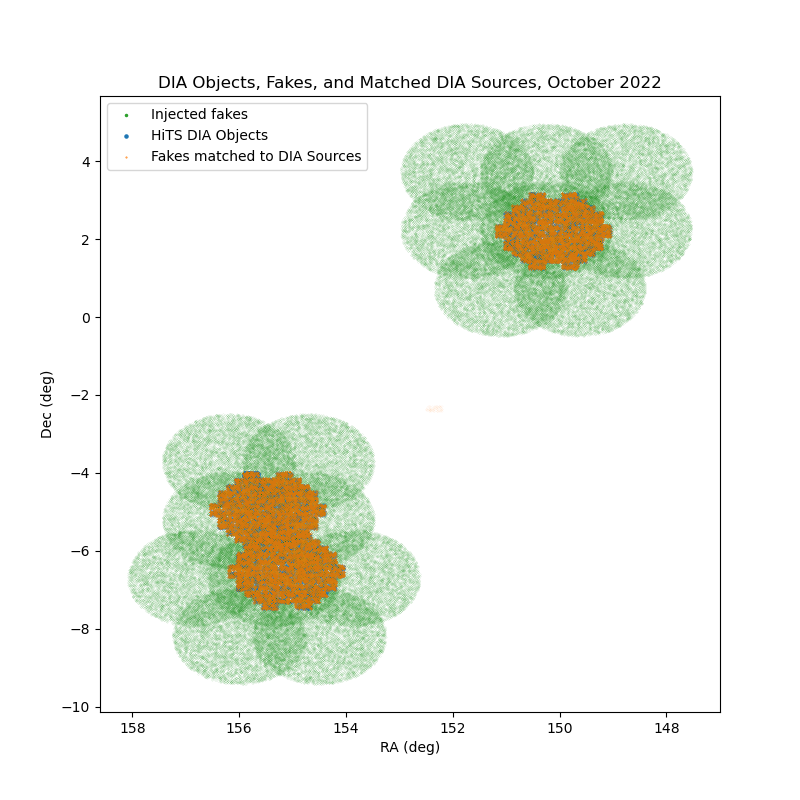

In [22]:
plt.figure(figsize=(8,8))
plt.plot(allInjectedFakes.ra*u.rad.to(u.deg), allInjectedFakes.dec*u.rad.to(u.deg),
         ls='None', marker='.', ms=0.1, label="Injected fakes", color='C2')
plt.plot(goodObj.ra, goodObj.decl, ls='None', marker='.', ms=0.15, label="HiTS DIA Objects", color='C0')
plt.plot(matchedDiaSources.ra_x*u.rad.to(u.deg), matchedDiaSources.dec*u.rad.to(u.deg), ls='None', marker='.',
         ms=0.03, label="Fakes matched to DIA Sources", color='C1')
plt.gca().invert_xaxis()
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.legend(markerscale=30)
plt.title(f'DIA Objects, Fakes, and Matched DIA Sources, {month} {year}')

In [23]:
nFakesGood = len(matchedDiaSources)
nFakesGood  # number of matched fake sources

456888

In [24]:
len(srcTable) - nFakesGood  # number of non-fake DIA Sources

763678

In [25]:
len(goodSrc)  # number of good sources

466119

visit 410915: 14216 DIA Sources, 5393 matched injected fakes
visit 410929: 17302 DIA Sources, 5362 matched injected fakes
visit 410931: 19323 DIA Sources, 5370 matched injected fakes
visit 410971: 16271 DIA Sources, 5397 matched injected fakes
visit 410985: 16582 DIA Sources, 5371 matched injected fakes
visit 410987: 18635 DIA Sources, 5371 matched injected fakes
visit 411021: 14918 DIA Sources, 5386 matched injected fakes
visit 411035: 16265 DIA Sources, 5376 matched injected fakes
visit 411037: 17257 DIA Sources, 5380 matched injected fakes
visit 411055: 16252 DIA Sources, 5401 matched injected fakes
visit 411069: 17881 DIA Sources, 5382 matched injected fakes
visit 411071: 19561 DIA Sources, 5374 matched injected fakes
visit 411255: 14148 DIA Sources, 5385 matched injected fakes
visit 411269: 17824 DIA Sources, 5377 matched injected fakes
visit 411271: 18892 DIA Sources, 5371 matched injected fakes
visit 411305: 16502 DIA Sources, 5391 matched injected fakes
visit 411319: 19253 DIA 

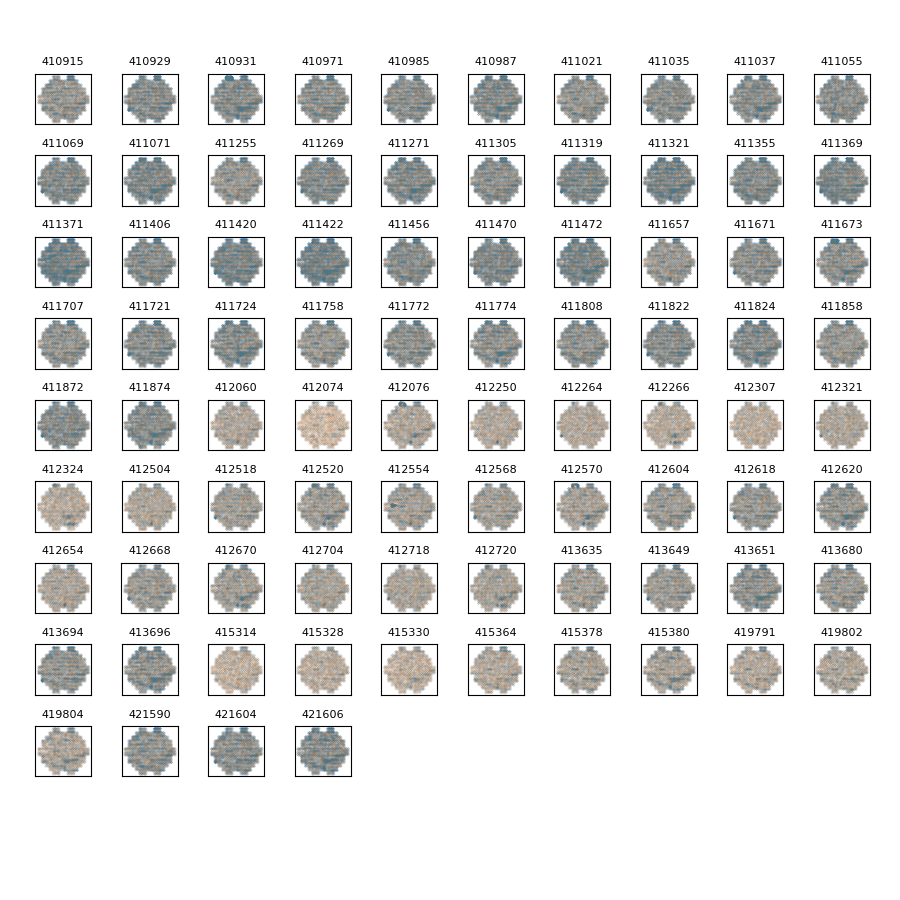

In [26]:
# Plot visit-by-visit: DIA Sources (blue) and inserted fakes (orange)

sourceTablePlot = srcTable
#sourceTablePlot = goodSrc

visits = np.unique(sourceTablePlot['visit'])
nVisits = len(visits)
if np.floor(np.sqrt(nVisits)) - np.sqrt(nVisits) == 0:
    squareGridSize = int(np.sqrt(nVisits))
else:
    squareGridSize = int(np.sqrt(nVisits)) + 1

fig = plt.figure(figsize=(9, 9))
for count, visit in enumerate(np.unique(sourceTablePlot['visit'].values)):
    idx = sourceTablePlot.visit == visit
    ax = fig.add_subplot(squareGridSize, squareGridSize, count + 1, aspect='equal')
    ax.scatter(sourceTablePlot.ra[idx], sourceTablePlot.decl[idx], c='C0', marker='.', s=0.01, alpha=0.3)
    
    fakeSources = matchedDiaSources.loc[matchedDiaSources.visit == visit]
    ax.scatter(fakeSources.ra_x*u.rad.to(u.deg), fakeSources.dec*u.rad.to(u.deg),
               c='C1', marker='.', s=0.01, alpha=0.3)
    
    ax.set_title(visit, size=8)
    ax.invert_xaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(f'visit {visit}: {len(sourceTablePlot.loc[sourceTablePlot.visit == visit])} DIA Sources, {len(fakeSources)} matched injected fakes')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0)

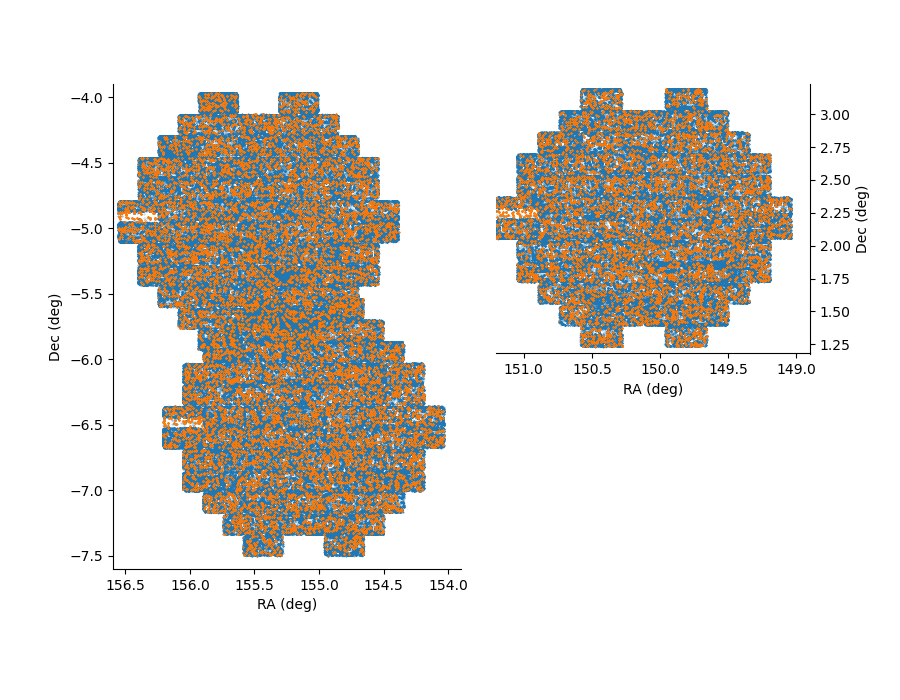

In [27]:
# Same as above but all on top of each other instead of broken out by visit
plt.figure(figsize=(9, 7))
ax1 = plt.subplot2grid((100, 100), (0, 55),
                       rowspan=50, colspan=45)  # 1 single HiTS field, on the right
ax2 = plt.subplot2grid((100, 100), (0, 0),
                       rowspan=90, colspan=50)  # 2 overlapping HiTS fields, on the left

ax1Filter = (srcTable['decl'] > -2)
ax2Filter = (~ax1Filter)

ax1.scatter(srcTable.loc[ax1Filter, 'ra'],
            srcTable.loc[ax1Filter, 'decl'],
            c='C0', s=0.1, alpha=0.5)
ax1.scatter(matchedDiaSources.ra_x*u.rad.to(u.deg), matchedDiaSources.dec*u.rad.to(u.deg), c='C1', s=0.05, alpha=0.5)
ax2.scatter(srcTable.loc[ax2Filter, 'ra'],
            srcTable.loc[ax2Filter, 'decl'],
            c='C0', s=0.1, alpha=0.5)
ax2.scatter(matchedDiaSources.ra_x*u.rad.to(u.deg), matchedDiaSources.dec*u.rad.to(u.deg), c='C1', s=0.05, alpha=0.5)

ax1.set_xlabel('RA (deg)')
ax2.set_xlabel('RA (deg)')
ax1.set_ylabel('Dec (deg)')
ax2.set_ylabel('Dec (deg)')

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax1.set_xlim(151.2, 148.9)
ax1.set_ylim(1.18, 3.23)
ax2.set_xlim(156.6, 153.9)
ax2.set_ylim(-7.6, -3.9)

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')

#plt.title(title)
plt.subplots_adjust(wspace=0.1, hspace=0)

Text(0.5, 1.0, 'Comparing DIA Object and Source counts')

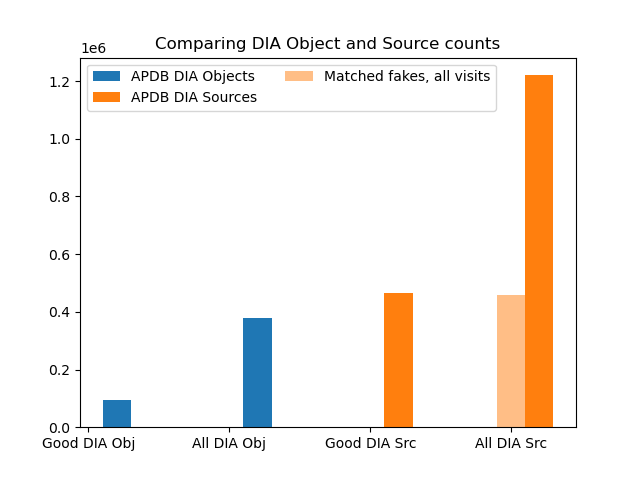

In [28]:
srcTable1 = matchedDiaSources
goodSrc1 = []

srcTable2 = srcTable
goodSrc2 = goodSrc
objTable2 = objTable
goodObj2 = goodObj

fig, ax = plt.subplots()
barLabels = ['Good DIA Obj', 'All DIA Obj', 'Good DIA Src', 'All DIA Src']
xbar = np.array([0, 1])
width = 0.2

# Current Run
ax.bar(xbar + width, [len(goodObj2), len(objTable2)], 
       width, label='APDB DIA Objects', color='C0')
ax.bar(xbar + 2 + width, [len(goodSrc2), len(srcTable2)],
       width, label='APDB DIA Sources', color='C1')

ax.bar(xbar + 2, [len(goodSrc1), len(srcTable1)],
       width, label='Matched fakes, all visits', color='C1', alpha=0.5)

plt.legend(ncol=2)
ax.set_xticks([0, 1, 2, 3])
labels = ax.set_xticklabels(barLabels)
plt.title('Comparing DIA Object and Source counts')

## 4. Fakes completeness analysis

In [29]:
def completenessByBandPlot(matchedDiaSources, bandList, colorList, flux_col_suffix='_mag', doRaDecCut=False):

    completeness_byband = {}
    completeness_err_byband = {}
    bins = np.linspace(20, 26, 70)
    
    # Some filters
    wScienceOnly = matchedDiaSources['isVisitSource'] & ~matchedDiaSources['isTemplateSource']
    wMatched = matchedDiaSources['diaSourceId'] > 0
    
    if doRaDecCut:
        # Spatial cut  # probably redundant now that we do RA/Dec cut in trimFakes
        minra = matchedDiaSources.loc[wScienceOnly & wMatched,'ra'].min()
        maxra = matchedDiaSources.loc[wScienceOnly & wMatched,'ra'].max()
        mindecl = matchedDiaSources.loc[wScienceOnly & wMatched,'decl'].min()
        maxdecl = matchedDiaSources.loc[wScienceOnly & wMatched,'decl'].max()
        wRADec = (matchedDiaSources.ra < maxra) & (matchedDiaSources.ra > minra) & \
                 (matchedDiaSources.decl > mindecl) & (matchedDiaSources.decl < maxdecl)

    for band in bandList:
        wband = matchedDiaSources['filterName'] == band

        if doRaDecCut:
            matched_filter = (wMatched & wScienceOnly & wRADec & wband)
            unmatched_filter = (~wMatched & wScienceOnly & wRADec & wband)
        else:
            matched_filter = (wMatched & wScienceOnly &  wband)
            unmatched_filter = (~wMatched & wScienceOnly & wband)

        n_matched, edges = np.histogram(matchedDiaSources.loc[matched_filter, f'{band}{flux_col_suffix}'], bins=bins)
        n_unmatched, edges = np.histogram(matchedDiaSources.loc[unmatched_filter, f'{band}{flux_col_suffix}'], bins=bins)

        ntot = n_matched + n_unmatched
        nmatched_err = np.sqrt(n_matched)
        completeness_byband[band] = n_matched/ntot

        # Attempt to compute some kind of error
        ntot_err = np.sqrt(ntot) # compute on total to keep Poisson errors in gaussian regime
        completeness_err_byband[band] = completeness_byband[band] * \
                                        np.sqrt((nmatched_err/n_matched)**2. + (ntot_err/ntot)**2.)
    
    plt.figure()
    plt.title('Spatial distribution of matched DIA Sources')
    plt.scatter(matchedDiaSources.loc[wScienceOnly & wMatched,'ra'], \
                matchedDiaSources.loc[wScienceOnly & wMatched,'decl'],
                marker='x', s=3, label='Matched science fake')
    plt.scatter(matchedDiaSources.loc[wScienceOnly & ~wMatched,'ra'], \
                matchedDiaSources.loc[wScienceOnly & ~wMatched,'decl'],
                marker='.', s=3, label='Unmatched science fake')
    #plt.scatter(matchedDiaSources.loc[wScienceOnly & wRADec,'ra'], \
    #            matchedDiaSources.loc[wScienceOnly & wRADec,'decl'],marker='+')
    plt.legend()
    
    if len(bandList) > 1:
        fig, axs = plt.subplots(3, 2, figsize=(9, 12))
        axG = axs[0, 0]
        axR = axs[0, 1]
        axI = axs[1, 0]
        axZ = axs[1, 1]
        axY = axs[2, 0]
        #axHits = axs[2, 1]
        ax0 = axs[2, 1]
        ax0.axis('off')
        axList = [axG, axR, axI, axZ, axY]
        colorList = ['C2', 'C1', 'C3', 'C5', 'k']
        xlim = (20,26)
        ylim = (0, 1)
        plt.setp(axs, xlim=xlim, ylim=ylim)
        fig.suptitle(f'Completeness')
        for ax, band, color in zip(axList, bandList, colorList):
            ax.errorbar(bins[0:-1], completeness_byband[band], completeness_err_byband[band], color=color)
    
    plt.figure(figsize=(8, 6))
    for band, color in zip(bandList, colorList):
        plt.errorbar(bins[0:-1], completeness_byband[band], completeness_err_byband[band], color=color, label=band)
        #plt.axvline(median_limmag.loc[band,'maglim6'], color=color, ls=':')
        #plt.axvspan(p25_limmag.loc[band,'maglim6'], p75_limmag.loc[band,'maglim6'],
        #            facecolor=color, alpha=0.2, edgecolor='none')
    plt.axhline(.9, ls='--', color='0.75')#, label='90%')
    plt.legend(loc='lower left')
    plt.xlabel('Injected magnitude')
    plt.ylabel('Fractional completeness')
    plt.title('Completeness for sources injected into science (visit) images')

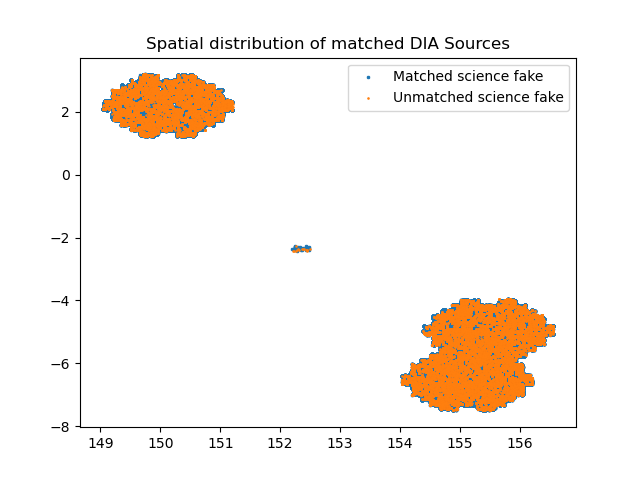

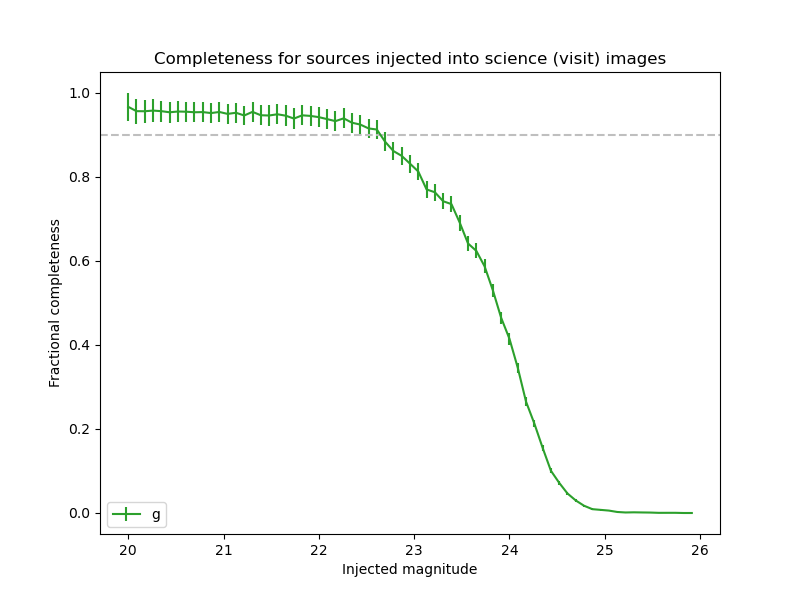

In [30]:
completenessByBandPlot(matchedDiaSources, bandList, colorList,
                       flux_col_suffix='_mag', doRaDecCut=False)

## 5. SNR distributions

For both difference image fluxes (psFlux) and forced source photometry fluxes (totFlux)
SNR is basically just flux/fluxErr for our purposes... but there is now an actual `snr` column in the DiaSource table too, even better!

Text(0.5, 0, 'SNR of DIA Sources')

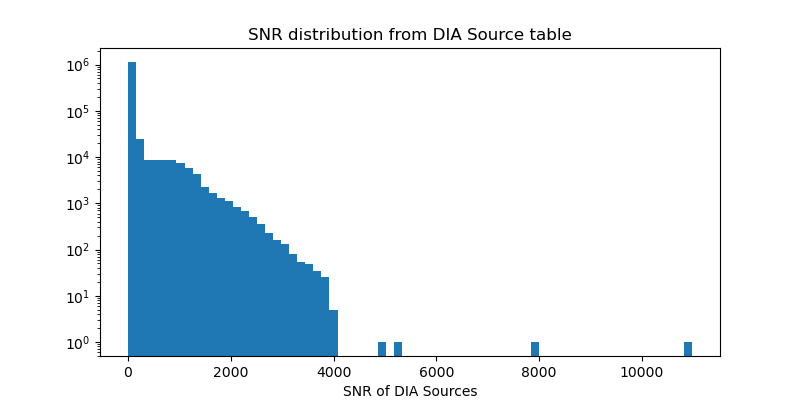

In [31]:
plt.figure(figsize=(8,4))
plt.yscale('log')
snrHist = plt.hist(srcTable.snr, bins=70)
plt.title('SNR distribution from DIA Source table')
plt.xlabel('SNR of DIA Sources')

In [32]:
# Pre-snr column:
srcTable['psFluxSNR'] = srcTable.psFlux / srcTable.psFluxErr
srcTable['totFluxSNR'] = srcTable.totFlux / srcTable.totFluxErr

Text(0.5, 0, 'psFlux/psFluxErr')

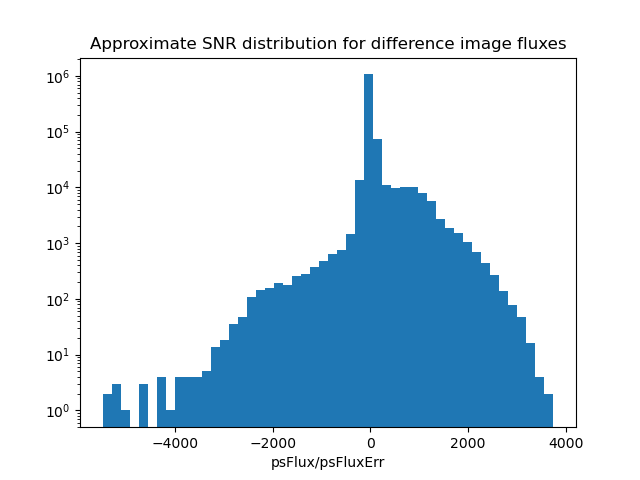

In [33]:
plt.figure()
plt.yscale('log')
psFluxHist = plt.hist(srcTable.psFluxSNR, bins=50)
plt.title('Approximate SNR distribution for difference image fluxes')
plt.xlabel('psFlux/psFluxErr')

Text(0.5, 0, 'totFlux/totFluxErr')

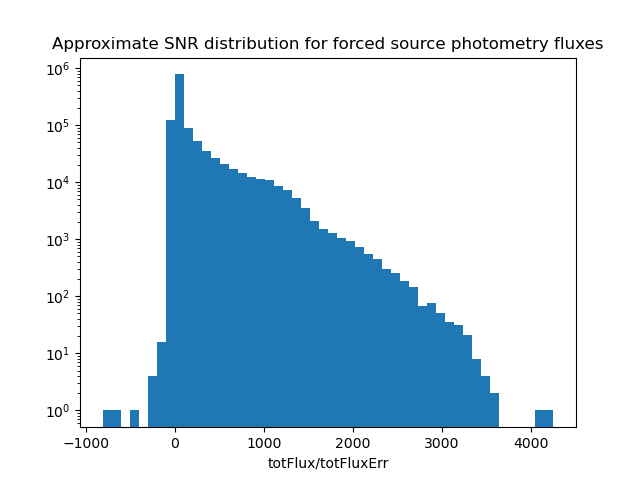

In [34]:
plt.figure()
plt.yscale('log')
totFluxHist = plt.hist(srcTable.totFluxSNR, bins=50)
plt.title('Approximate SNR distribution for forced source photometry fluxes')
plt.xlabel('totFlux/totFluxErr')